In [2]:
import pandas as pd
import mysql.connector
import os

In [4]:
# List of CSV files and their corresponding table names

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'gelocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

In [14]:
# Connect to the MySQL database
conn = mysql.connector.connect(
      host = "localhost",
      user = "root",
      password = "Hirdeshpal15@",
      database = "ecommerce"
)

cursor = conn.cursor()


# Folder containing the CSV files
folder_path = '/Users/hirdeshpal/Downloads/Coding/SQL/Project/Ecommerce'



def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Let Start with the queries


In [621]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


# Connect to the MySQL database
db = mysql.connector.connect(
        host = "localhost",
        user = "root",
        password = "Hirdeshpal15@",
        database = "ecommerce"    
)


# create a medium b/w python n mysql to run the queries
cur = db.cursor()


### 1. List all unique cities where customers are located.

In [624]:


query_1 = """ SELECT DISTINCT
                (geolocation_city) AS unique_citys
            FROM
                gelocation """  


cur.execute(query_1)

data_1 = cur.fetchall()

df = pd.DataFrame(data_1, columns = ['unique_cities'])
df.head(5)

,unique_cities
0,sao paulo
1,sao bernardo do campo
2,jundiaí
3,taboão da serra
4,sãopaulo


### 2. Count the number of orders placed in 2017

In [627]:
query_2 = """ 

SELECT 
    COUNT(*) AS puchased_year
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2017 
    
""" 


cur.execute(query_2)

data_2 = cur.fetchall()

print(f"The total number of orders placed in 2017 is: {data_2[0][0]} " )



The total number of orders placed in 2017 is: 45101 


### 3. Find the total sales per category

In [630]:


query_3 = """ 

SELECT 
    lower(p.product_category),
    ROUND(SUM(pay.payment_value),2) AS Total_sales
FROM
    products p
        JOIN
    order_items ot ON p.product_id = ot.product_id
        JOIN
    payments pay ON pay.order_id = ot.order_id
GROUP BY p.product_category
ORDER BY Total_sales DESC 


"""

cur.execute(query_3)

data_3 = cur.fetchall()

# data_3

df =  pd.DataFrame(data_3, columns = ['Category','Total_sales'])
df

,Category,Total_sales
0,bed table bath,1712553.67
1,health beauty,1657373.12
2,computer accessories,1585330.45
3,furniture decoration,1430176.39
4,watches present,1429216.68
...,...,...
69,pc gamer,2174.43
70,house comfort 2,1710.54
71,cds music dvds,1199.43
72,fashion children's clothing,785.67


### 4. Calculate the percentage of orders that were paid in installments.

In [633]:


query_4 = """ 

SELECT 
    CONCAT(((SELECT 
                            COUNT(payment_installments) AS count
                        FROM
                            payments
                        WHERE
                            payment_installments >= 1) / COUNT(payment_installments)) * 100,
            ' %') AS Total_installment_percentage
FROM
    payments


"""

cur.execute(query_4)

data_4 = cur.fetchall()

print(f'The total percentage of orders that were paid in installments: {data_4[0][0]} ')

# Note:- Considering instalment as payment_installments>=1 as there are instalment with zero value

The total percentage of orders that were paid in installments: 99.9981 % 


### 5. Count the number of customers from each state.

In [636]:
 

query_5 = """

SELECT 
    customer_state, COUNT(*) AS num_of_cust
FROM
    customers
GROUP BY customer_state
ORDER BY num_of_cust DESC

"""

cur.execute(query_5)

data_5 = cur.fetchall()

df = pd.DataFrame(data_5, columns = ['custemer_state','no_of_customers'])
df

,custemer_state,no_of_customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


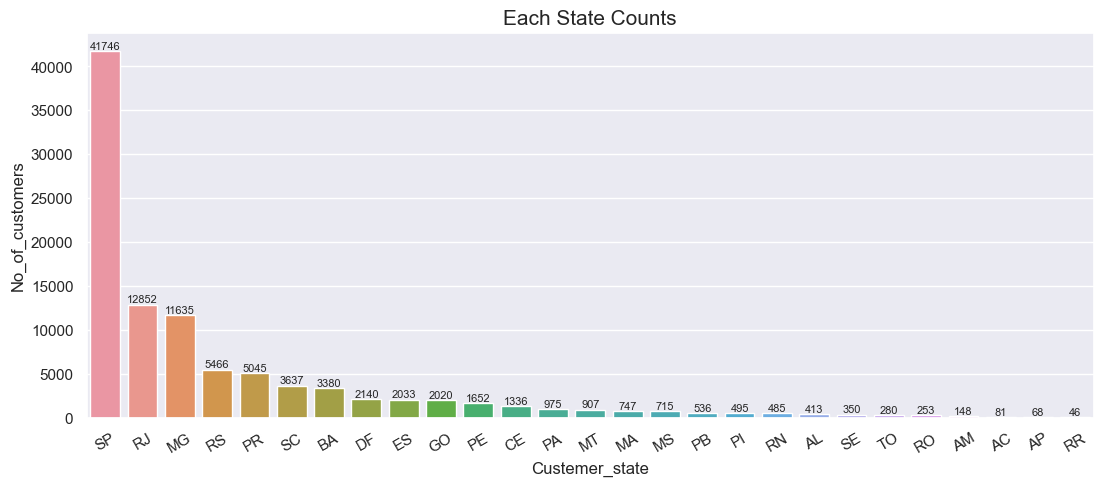

In [638]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x=df['custemer_state'],y=df['no_of_customers'])

# Add labels on bars
ax.bar_label(ax.containers[0],fontsize=8)

plt.title("Each State Counts", fontsize=15)
plt.xlabel("Custemer_state", fontsize=12,)
plt.ylabel("No_of_customers",fontsize=12)
plt.xticks(rotation=30)
plt.show()

### 6. Calculate the number of orders per month in 2018. 

In [641]:


# date_format(order_purchase_timestamp,'%b') AS month_name

query_6 = """

SELECT 
    monthname(order_purchase_timestamp) AS months,       # used 'monthname' in small letters
    COUNT(*) AS order_count
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY months

"""

cur.execute(query_6)

data_6 = cur.fetchall()

df = pd.DataFrame(data_6, columns = ['months','order_count'])
df



,months,order_count
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


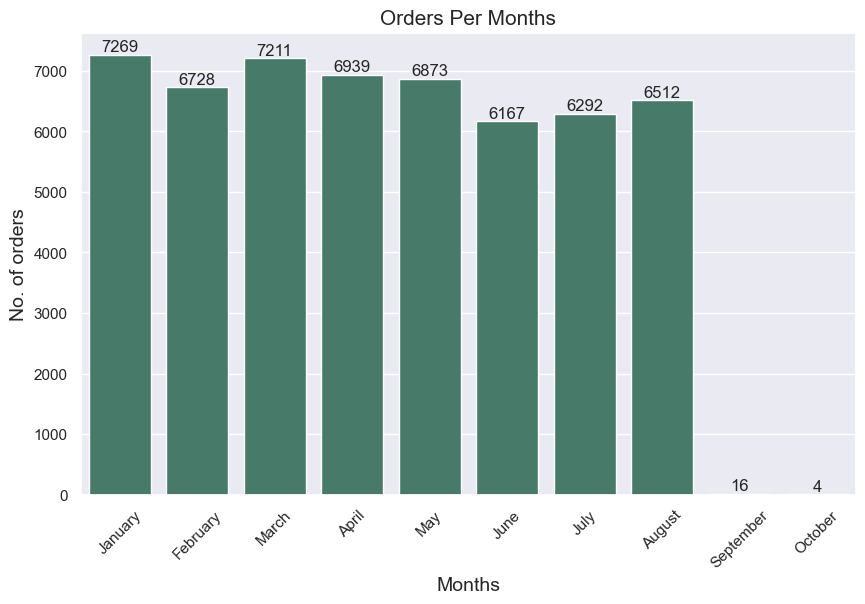

In [643]:
# Define the month order
month_order = ["January", "February","March","April","May","June","July","August","September","October"]


# Define Viridian color
viridian_color = "#40826D"


plt.figure(figsize=(10,6))
ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = month_order, color = viridian_color)

# Add labels on bars
ax.bar_label(ax.containers[0])
plt.title("Orders Per Months", fontsize=15)
plt.xlabel("Months", fontsize=14,)
plt.ylabel("No. of orders",fontsize=14)
plt.xticks(rotation=45)
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [650]:


query_7 = """

WITH count_per_order AS
(SELECT 
    o.order_id, o.customer_id, COUNT(ot.order_id) AS oc
FROM
    orders o
        JOIN
    order_items ot ON o.order_id = ot.order_id
GROUP BY o.order_id , o.customer_id)

SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM
    customers
        JOIN
    count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city;

"""



cur.execute(query_7)

data_7 = cur.fetchall()

df = pd.DataFrame(data_7, columns = ['customer_city','average_orders'])
df

,customer_city,average_orders
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [655]:
query_8 = """

SELECT 
    LOWER(p.product_category) AS Category,
    CONCAT(ROUND((SUM(pay.payment_value) / (SELECT 
                            SUM(payment_value)
                        FROM
                            payments)) * 100,
                    4),
            ' %') AS Total_sales_per
FROM
    products p
        JOIN
    order_items ot ON p.product_id = ot.product_id
        JOIN
    payments pay ON pay.order_id = ot.order_id
GROUP BY p.product_category
order by Total_sales_per DESC;

"""



cur.execute(query_8)

data_8 = cur.fetchall()

df = pd.DataFrame(data_8, columns = ['Category','Total_sales_per'])
df


,Category,Total_sales_per
0,computer accessories,9.9028 %
1,furniture decoration,8.9336 %
2,watches present,8.9277 %
3,sport leisure,8.696 %
4,housewares,6.8384 %
...,...,...
69,pc gamer,0.0136 %
70,house comfort 2,0.0107 %
71,cds music dvds,0.0075 %
72,fashion children's clothing,0.0049 %


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [659]:
query_9 = """

SELECT 
    products.product_category,
    COUNT(*) AS no_time_purchsed,
    ROUND(AVG(order_items.price), 2) AS avg_price
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category;

"""



cur.execute(query_9)

data_9 = cur.fetchall()

df = pd.DataFrame(data_9, columns = ['product_category','no_time_purchsed','avg_price'])
df



,product_category,no_time_purchsed,avg_price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


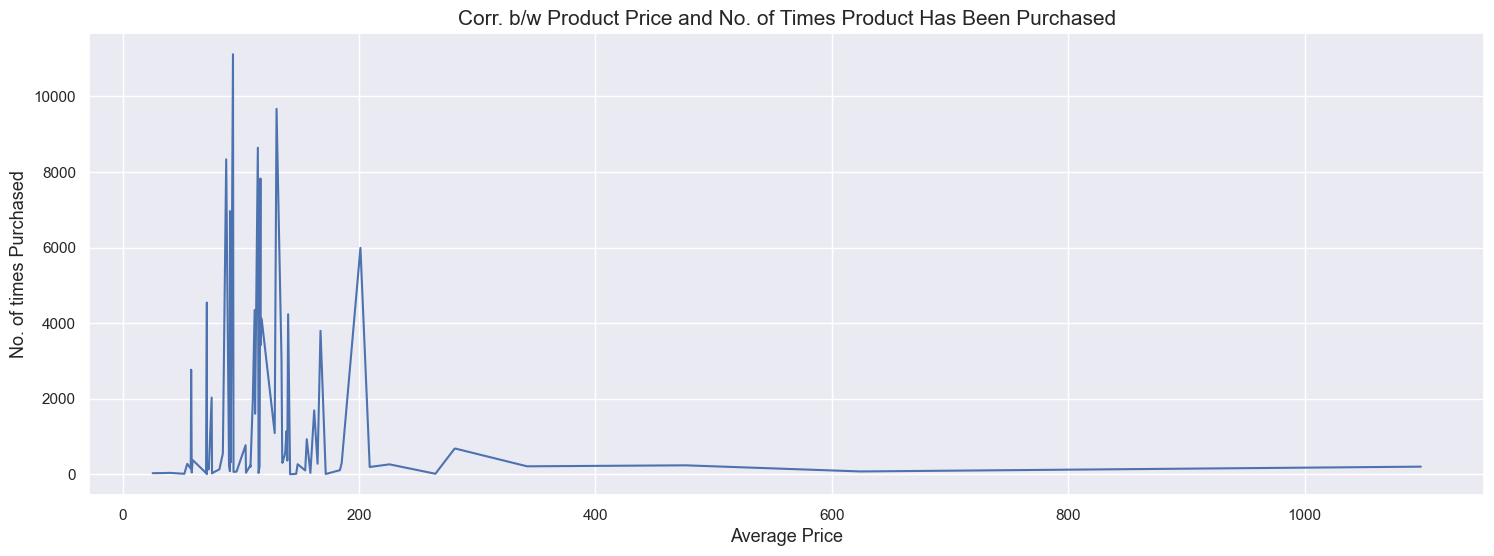

In [661]:
plt.figure(figsize = (18,6))
sns.lineplot(data=df,y=df['no_time_purchsed'],x=df['avg_price'])
plt.title("Corr. b/w Product Price and No. of Times Product Has Been Purchased", fontsize=15)
plt.xlabel("Average Price", fontsize=13,)
plt.ylabel("No. of times Purchased",fontsize=13)
plt.show()

### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [664]:
query_10 = """

SELECT *,
    DENSE_RANK() OVER(ORDER BY Revenue DESC) AS Rank_num
FROM    
(SELECT 
    order_items.seller_id,
    ROUND(SUM(payments.payment_value), 2) AS Revenue
FROM
    payments
        JOIN
    order_items ON payments.order_id = order_items.order_id
GROUP BY order_items.seller_id) as a

"""



cur.execute(query_10)

data_10 = cur.fetchall()

df = pd.DataFrame(data_10, columns = ['seller_id','Revenue','Rank_Number'])
df



,seller_id,Revenue,Rank_Number
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


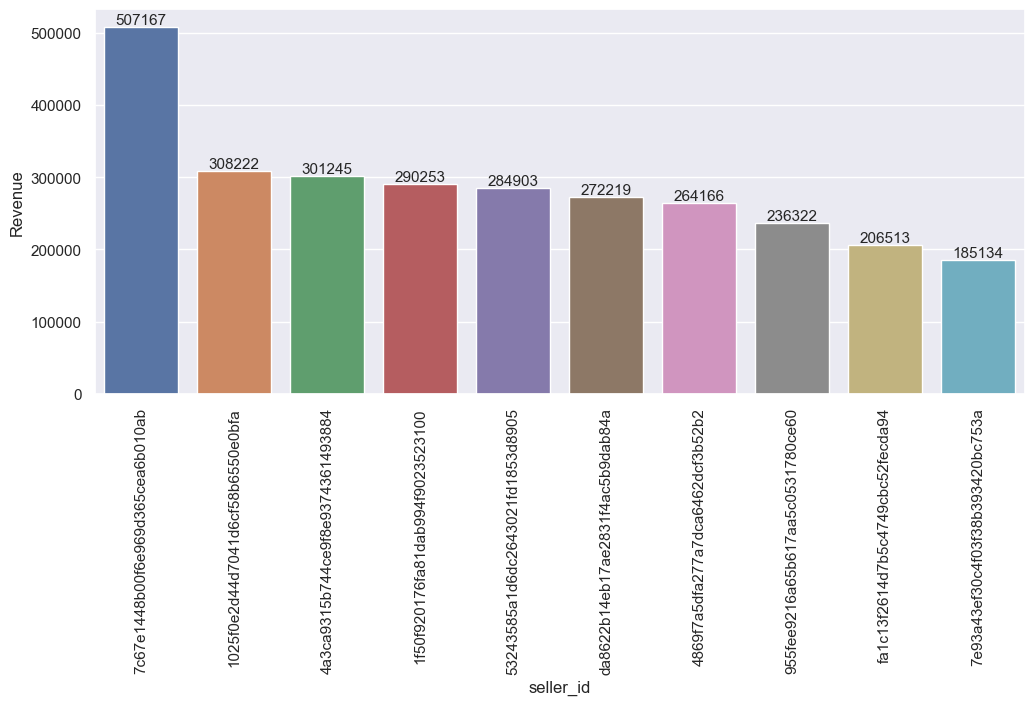

In [666]:
# Considering only top 10 sellers
df = df.head(10)

plt.figure(figsize=(12,5))
ax = sns.barplot(x = df['seller_id'],y = df['Revenue'],data = df)
ax.bar_label(ax.containers[0], fontsize = 11)
plt.xticks(rotation = 90)
plt.show()


### 11. Calculate the moving average of order values for each customer over their order history

In [671]:
query_11 = """

SELECT customer_id,
	order_purchase_timestamp,
    payment, 
	ROUND(AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2) AS mov_avg
FROM     
(SELECT 
    orders.customer_id,
    orders.order_purchase_timestamp,
    payments.payment_value AS payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id) AS a;

"""



cur.execute(query_11)

data_11 = cur.fetchall()

df = pd.DataFrame(data_11, columns = ['customer_id','order_purchase_timestamp','payment','mov_avg'])
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


### 12. Calculate the cumulative sales per month for each year.

In [674]:
query_12 = """

SELECT 	Concat(Years,'-',Months) as Years_months,
        total_sales,
        Round(sum(total_sales) OVER(ORDER BY Years,Months),2) AS Cumlative_sales
FROM 
(SELECT 
	YEAR(orders.order_purchase_timestamp) AS Years,
    MONTH(orders.order_purchase_timestamp) AS Months,
    ROUND(SUM(payments.payment_value),2) AS total_sales
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY Years,Months
ORDER BY Years,Months) AS a;

"""

cur.execute(query_12)

data_12 = cur.fetchall()

df = pd.DataFrame(data_12, columns = ['Years_months','total_sales','Cumlative_sales'])
df



,Years_months,total_sales,Cumlative_sales
0,2016-9,252.24,252.24
1,2016-10,59090.48,59342.72
2,2016-12,19.62,59362.34
3,2017-1,138488.04,197850.38
4,2017-2,291908.01,489758.39
5,2017-3,449863.60,939621.99
6,2017-4,417788.03,1357410.02
7,2017-5,592918.82,1950328.84
8,2017-6,511276.38,2461605.22
9,2017-7,592382.92,3053988.14


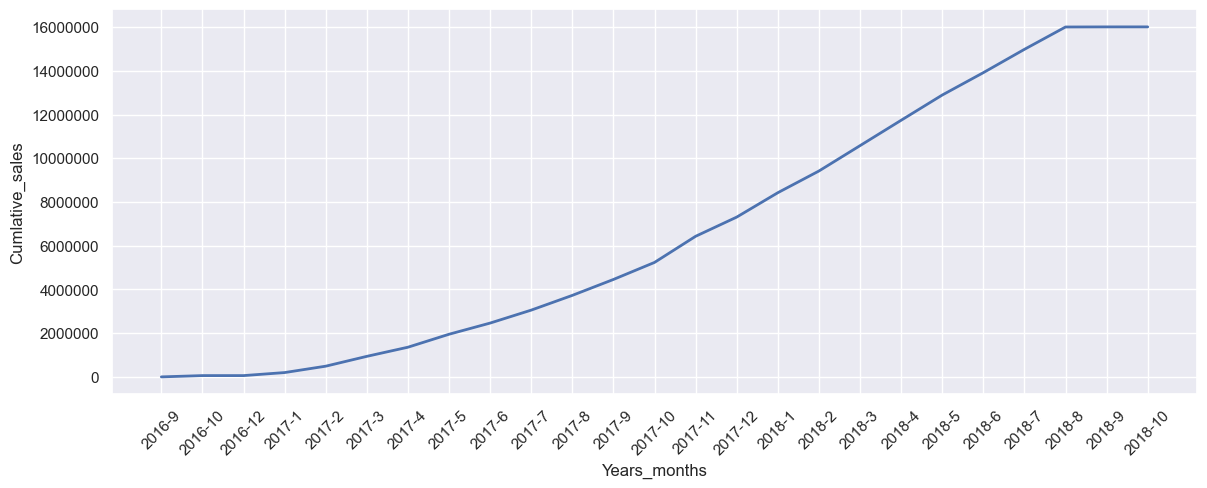

In [676]:
plt.figure(figsize=(14,5))
sns.lineplot(x = df['Years_months'],y=df['Cumlative_sales'], data = df,linewidth = 2)

#Added formatter to show exact values instead of scientific values
plt.ticklabel_format(style = 'plain',axis = 'y')
plt.xticks(rotation = 45)
plt.show()


### 13. Calculate the year-over-year growth rate of total sales

In [679]:
query_13 = """

WITH a as
(SELECT 
	YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value),2) AS sales
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY Years
ORDER BY Years)

SELECT  years,
        sales,
        lag(sales,1) over(order by years) as previous_year,
        ROUND(((sales-lag(sales,1) over(order by years))/lag(sales,1) over(order by years))*100,2)
FROM a;        

"""

cur.execute(query_13)

data_13 = cur.fetchall()

df = pd.DataFrame(data_13, columns = ['years','sales','Previous_year','yoy % growth'])
df

,years,sales,Previous_year,yoy % growth
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [683]:


query_14 = """

WITH a AS (SELECT 
    customers.customer_id,
    MIN(orders.order_purchase_timestamp) first_order
FROM
    customers
        JOIN
    orders ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),


b AS (SELECT 
    a.customer_id,
    COUNT(DISTINCT orders.order_purchase_timestamp) next_order
FROM
    a
        JOIN
    orders ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > first_order
        AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
GROUP BY a.customer_id) 


SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id))
FROM
    a
        LEFT JOIN
    b ON a.customer_id = b.customer_id ;         

"""

cur.execute(query_14)

data_14 = cur.fetchall()

df = pd.DataFrame(data_14)
df

# Since there was no such customer found thats why it is 0

,0
0,None


### 15. Identify the top 3 customers who spent the most money in each year.

In [686]:
query_15 = """

SELECT years, customer_id, payment, d_rank
FROM
(SELECT 
    YEAR(orders.order_purchase_timestamp) years,
    orders.customer_id,
    SUM(payments.payment_value) payment,
    dense_rank() over(partition by year(orders.order_purchase_timestamp)
    order by sum(payments.payment_value) desc) d_rank
FROM orders 
	JOIN payments 
		ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp),
              orders.customer_id) AS a

WHERE d_rank <= 3 ;


"""

cur.execute(query_15)

data_15 = cur.fetchall()

df = pd.DataFrame(data_15,columns = ['years','id','payment','rank'])
df



,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


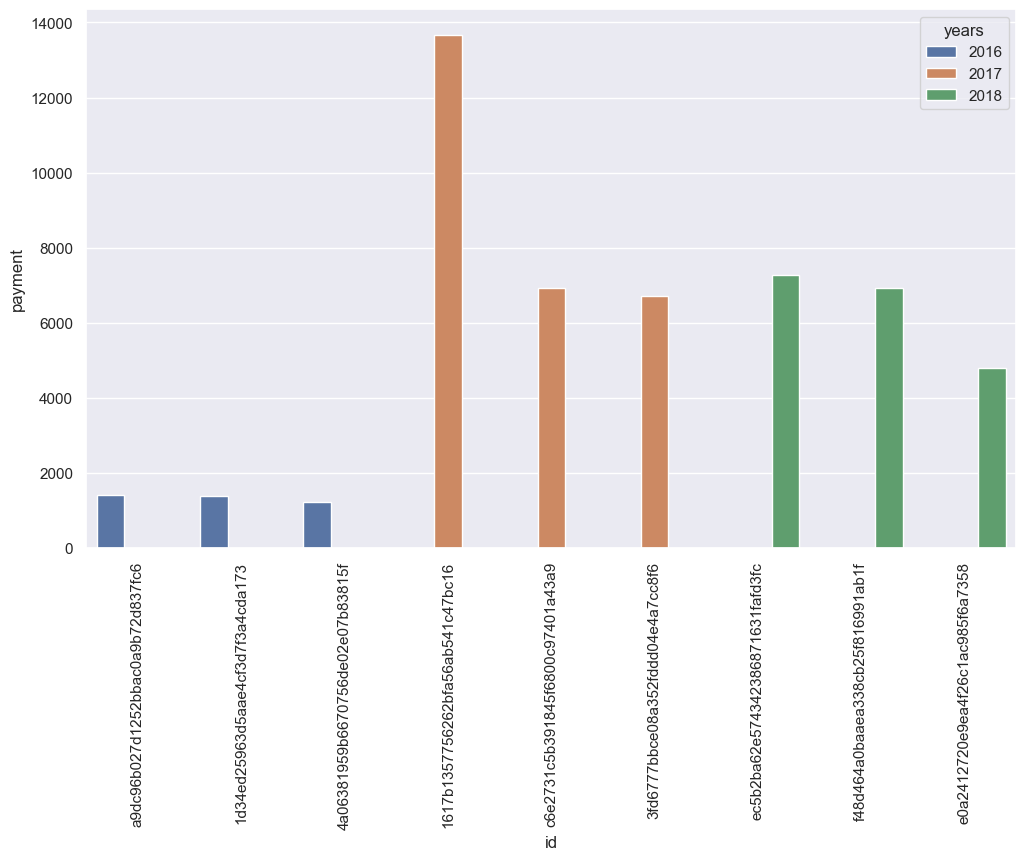

In [688]:
plt.figure(figsize=(12,7))
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()